In [ ]:
!pip install -U langchain_community langgraph langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.5/82.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.8/473.8 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found exi

#### **상태 설정**

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ['TAVILY_API_KEY'] = userdata.get('tavily')

In [ ]:
# 필요한 타입 힌트 및 기능을 불러옵니다.
from typing import Annotated  # 타입 힌트를 확장하여 메타데이터나 추가 동작을 부여할 수 있음
from typing_extensions import TypedDict  # 딕셔너리 형태의 고정된 구조를 타입으로 지정할 수 있게 함
from langgraph.graph.message import add_messages  # LangGraph의 메시지 관련 기능을 제공하는 유틸리티

# 대화 상태(state)를 정의하는 클래스입니다.
class State(TypedDict):
    # 'messages' 필드는 메시지들의 리스트입니다.
    # Annotated를 통해 이 필드에 대해 추가적인 기능(add_messages)을 부여합니다.
    # add_messages는 LangGraph에서 메시지를 추가/추적할 수 있도록 도와주는 역할을 합니다.
    messages: Annotated[list, add_messages]

#### **ToolNode로 도구 노드 구축**

In [ ]:
# Tavily 검색 툴을 LangChain 커뮤니티 모듈에서 불러옵니다.
from langchain_community.tools.tavily_search import TavilySearchResults

# LangGraph에서 툴 노드 및 조건 분기 관련 유틸리티를 불러옵니다.
from langgraph.prebuilt import ToolNode, tools_condition

# Tavily 검색 툴을 초기화합니다.
# max_results=2는 최대 2개의 검색 결과만 가져오도록 설정합니다.
tool = TavilySearchResults(max_results=2)

# 사용할 툴들을 리스트로 구성합니다.
# LangGraph는 여러 툴을 동시에 등록할 수 있기 때문에 리스트로 정의합니다.
tools = [tool]

# 툴을 사용하는 노드를 생성합니다.
# ToolNode는 주어진 툴들을 기반으로 사용자 입력에 따라 해당 툴을 호출하는 기능을 합니다.
tool_node = ToolNode(tools)

/tmp/ipython-input-1210479719.py:9: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=2)


#### **Tool 호출요청을 처리하는 기본노드 정의**

In [ ]:
import json

# LangChain에서 툴 응답 메시지를 나타내는 객체를 가져옵니다.
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """AIMessage에서 요청한 툴을 실행하는 기본 노드 클래스"""

    def __init__(self, tools: list) -> None:
        # 툴 목록을 {툴 이름: 툴 인스턴스} 형태의 딕셔너리로 변환해 저장합니다.
        # 나중에 툴 이름으로 빠르게 접근하기 위해 사용됩니다.
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 입력에서 messages 리스트를 가져옵니다. 없으면 빈 리스트 반환
        if messages := inputs.get("messages", []):
            # 가장 마지막 메시지(가장 최신 AIMessage)를 가져옵니다.
            message = messages[-1]
        else:
            # 메시지가 없을 경우 예외 발생
            raise ValueError("No message found in input")

        outputs = []  # 툴 실행 결과를 저장할 리스트

        # 메시지 내 포함된 툴 호출 요청들을 하나씩 처리합니다.
        for tool_call in message.tool_calls:
            # tool_call["name"]에 해당하는 툴을 찾아 실행하고 결과를 받습니다.
            # tool_call["args"]는 해당 툴에 전달할 인자입니다.
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )

            # 실행 결과를 ToolMessage로 감싸서 outputs에 추가합니다.
            # ToolMessage는 LangGraph/LangChain에서 툴 실행 응답을 표현하는 객체입니다.
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),     # 툴 결과를 JSON 문자열로 변환
                    name=tool_call["name"],              # 어떤 툴에서 실행되었는지 이름 명시
                    tool_call_id=tool_call["id"],        # 고유 ID로 호출 응답을 연결
                )
            )

        # 새로운 메시지 리스트를 반환합니다 (ToolMessage 형식)
        return {"messages": outputs}


#### **LLM 챗봇 설정**

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}

#### **그래프 구축**

In [ ]:
# LangGraph의 상태 기반 그래프를 정의하기 위한 모듈을 가져옵니다.
from langgraph.graph import StateGraph

# StateGraph 객체를 생성합니다.
# 이때 앞서 정의한 State (예: {"messages": ...}) 구조를 사용합니다.
graph_builder = StateGraph(State)

# "chatbot"이라는 이름으로 LLM 노드를 추가합니다.
graph_builder.add_node("chatbot", chatbot)  # LLM node

# "tools"라는 이름으로 툴 실행 노드를 추가합니다.
graph_builder.add_node("tools", tool_node)  # Tool node

# 툴 실행이 끝나면 chatbot으로 흐름이 이어지도록 edge(엣지)를 정의합니다.
graph_builder.add_edge("tools", "chatbot")

# chatbot 실행 후 다음 흐름을 조건에 따라 분기 처리하도록 설정합니다.
# tools_condition은 예를 들어 툴을 호출해야 하는지 여부를 판단하는 함수입니다.
graph_builder.add_conditional_edges("chatbot", tools_condition)

# 그래프의 시작점을 "chatbot" 노드로 지정합니다.
graph_builder.set_entry_point("chatbot")

# 그래프를 컴파일하여 실행 가능한 형태로 만듭니다.
graph = graph_builder.compile()

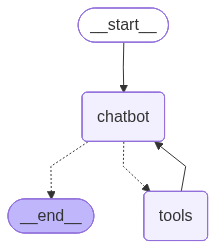

In [ ]:
from IPython.display import Image, display

# PNG 시도
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"PNG 출력 실패: {e}")
    # Mermaid 텍스트 직접 출력
    print(graph.get_graph().draw_mermaid())

**인터넷 검색이 필요한 질문**

In [ ]:
graph.invoke({"messages": {"role": "user", "content": "지금 미국 대통령은 누구야?"}})

{'messages': [HumanMessage(content='지금 미국 대통령은 누구야?', additional_kwargs={}, response_metadata={}, id='21dbb752-b1da-4e35-8279-0d56d959ee53'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 87, 'total_tokens': 107, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-Cf2Pqzkb24NgzxFpJbCJTY8BjCtHb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--2afeb9c0-4871-42c2-8347-952afafe4cc3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '현재 미국 대통령'}, 'id': 'call_Inek2YKZZYTcZdcc04ieLWEt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 87, 'output_tokens': 20, 't

In [ ]:
result = graph.invoke({
    "messages": [("user", "지금 미국 대통령은 누구야?")]
})
print(result["messages"][-1].content)


현재 미국 대통령은 도널드 트럼프입니다. 그는 2025년 1월 20일부터 대통령직을 맡고 있습니다. 더 자세한 내용은 [위키백과](https://en.wikipedia.org/wiki/President_of_the_United_States)에서 확인할 수 있습니다.
